# SLO Alerting Simulator

In [3]:
%matplotlib ipympl

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

plt.close('all')

In [4]:
# Import CSV data from csv file exported from Grafana panel

# !cp "$(ls -t /host/root/share/hhartmann/pub/*.csv | head -n1)" ./data.csv
!head data.csv

﻿"Time","Notify anomaly Ops per min","Notify anomaly Error ratio"
2023-06-22 09:28:37,3.88,
2023-06-22 09:28:37,,0
2023-06-22 09:44:52,3.32,
2023-06-22 09:44:52,,0
2023-06-22 10:01:07,4.31,
2023-06-22 10:01:07,,0
2023-06-22 10:17:22,4.62,
2023-06-22 10:17:22,,0
2023-06-22 10:33:37,6.15,


In [5]:
def df_grafana(filename="data.csv"):
    df = pd.read_csv("data.csv")
    df["Time"] = pd.to_datetime(df["Time"])

    # remove duplicate index entries
    df = df.groupby('Time').first().reset_index() 

    # Normalize column names to "total", "bad"
    df.index = df["Time"]
    del df["Time"]
    df.columns = ['total', 'bad_pct']
    df["bad"] = df['total'] * df['bad_pct'] / 100
    del df["bad_pct"]

    # Resample to one sample per minute
    df = df.asfreq('1T').interpolate()
    
    return df

In [6]:
def df_step(total_duration = "30d", error_duration = "6h", error_rate = 0.20):
    total_duration = pd.to_timedelta(total_duration)
    error_duration = pd.to_timedelta(error_duration)
    start_time = pd.Timestamp('2023-01-01')
    end_time = start_time + total_duration
    mid_time =  start_time + total_duration / 2

    df = pd.DataFrame(index=pd.date_range(start=start_time, end=end_time, freq='1min'))
    df['total'] = np.random.normal(loc=100, scale=2, size=len(df))
    df['total'] = df['total'].clip(lower=0)
    df['err_rate'] = 0
    df.loc[mid_time:mid_time + error_duration, 'err_rate'] = error_rate
    df['bad'] = df['total'] * df['err_rate']
    del df['err_rate']
    return df

<Axes: xlabel='Time'>

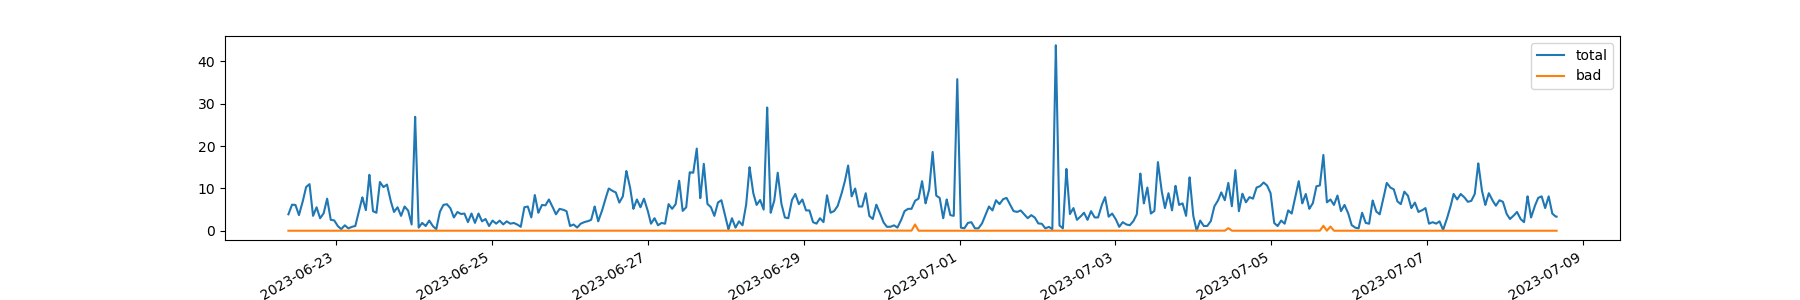

In [8]:
df = df_grafana()
# df = df_step("1d", "6h", 0.5)
df.plot(figsize=(18,3))

Time is represented by integer values. Each value corresponds to a single minute.

* t= 0 = NOW
* t= -1 = one minute ago
* t= -30d := -30 * 24 * 60 = one day ago

A time Series $X$ is a map, that associates a (real/float) number $X(t)$ for each time $t$.

Since we can't look into the future, we should not assume values of $R(t)$ for t>0.

For a time series $X$ we introduce the notation:

* $X(0)$ = Current value of $X$.
* $X(t)$ = value at time t
* $X(a:b) = [X(a+1), X(a), \dots, X(b)]$ for $a<b$. This is a vector in ${\mathbb R}^n$
* $X(-p:0)$ = vector with the latest $p$ values

For a Series X(t), we define the rolling sum of duration $d$ as

$$ RSUM_d[X](t) := \sum X(t-p : t) := \sum_{0 \leq i < d} X(t-i) $$



## SLO Math

### SLI

We now consider an SLO dataset $R$ represented by the following series:

* $R_{total}(t)$ = total requests at time t
* $R_{bad}(t)$ = bad requests at time t
* $R_{good}(t)$ = good requests at time t

Which satisfy the following identity:

$ R_{total}(t) = R_{bad}(t) + R_{good}(t) $

To define an SLO on the dataset, we need a SLO_period $(= 30d)$ and an SLO_target $(0.99)$.

The we define the SLI for R as:

$$ SLI[R] = RSUM_\text{SLO-period}[R_{good}] /  RSUM_\text{SLO-period}[R_{total}] $$

So in the example, the SLI value at time $t$ is the number of good events over the last 30 days divided by the total number of events over the past 30 days.

We say the SLO is met, if $SLI[R](t) > \text{SLO-target}$.

Properties:

* $0 \leq SLI[R](t) \leq 1$
* We have $SLI[R](t) = 1$ if and only if there were no bad requests in the SLO period ending at time $t$.
* We have $SLI[R](t) = 0$ if and only if there were no good requests in the SLO period ending at time $t$.

Remark: If we did not have any requests in the SLO period the SLI is underfined, since we can't divide by zero.

### Log ELI and number of Nines

SLI values are close to one (0.999). It will simplify our analysis if we will work with the complements,
which are close to zero (0.001).

We define the Error Level Indicator (ELI) as:

$$ 
  ELI[R] = RSUM_\text{SLO-period}[R_{bad}] /  RSUM_\text{SLO-period}[R_{total}] = 1 - SLI[R]
$$

We want the ELI to be lower than the Error Level Objective: ELO_target = 1 - SLO_target.
The ELO-target represents the tolerated error rate.

$$
  ELI[R] < \text{ELO-target}
$$

And the Log-ELI, aka. "Nines" function as:

$$ 
  Nines[R] := LogELI[R]: t \mapsto - Log_{10}( ELI[R](t) )
$$

So if SLI(t) = 0.999 then LogELI = 3.

### Error Budgets

The SLO-target can be translated into a number of errors which we are tolerating.
If the slo dataset R has $R_{total} = constant$ then we can allowed to accumulate 
$$
    \text{Error Budget} = \text{SLO-Period} \times \text{request rate} \times \text{ELO-target}
$$

Example: `(SLO-period = 30 days) x (Request Rate = 100 rps) x (ELO = 0.001) = 259,200 allowed errors in 30 days`

In this case the available error budget is
$$
\text{Error Budget} - \text{(Accumulated Errors over past 30 days)} = \text{Error Budget} - RSUM_\text{SLO-period}[R_{bad}]
$$
The actual definitions have to take into account that $R_{total}$ is non-constant.

The Error Budget is defined as:

$$
    ERR[R] = RSUM_\text{SLO-period}[R_{total}] \times \text{(ELO-target)} - RSUM_\text{SLO-perdio}[R_{bad}]
$$

So
$$
   \text{(Error Budget available now)} = \text{(Total number of requests current SLO-period)} \times \text{(allowable error rate)} - \text{(Errors during current SLO-period)}
$$
Example:
$$
   10,000 = (100,000,000) \times (0.001) - 990,000
$$


### Burn Rate

Burn rate is a concept that is best explained by example:

* With burn_rate = 1, we deplete the error budget exactly until the SLO period is done
* With burn_rate = 2, we deplete the error budget in half the SLO period time
* With burn_rate = 30, we deplete the error budget in 1/30 of the SLO period. If SLO_period = 30d, then this is the case after one day.

This result is achieved with the following mathematical definition:
$$
    \mathrm{BURN\_RATE}[R](t) = R_{bad}(t) \times (\text{SLO-period}) / (RSUM_\text{SLO-period}[R_{total}](t) \times \text{ELO-target})
$$
So:
$$
   \text{(Burn Rarte right now)} = \text{(Errors in last minute)} \times \text{(minutes in SLO-period)} / (\text{(total requests in last SLO-period)} \times \text{tolerated error rate})
$$
Example:

In [9]:
def df_add_slo(df, SLO_period = "3d", SLO_target = 0.995):
    SLO_period = pd.to_timedelta(SLO_period)
    tolerated_error_rate = (1-SLO_target)
    SLO_period_n = SLO_period / pd.to_timedelta('1T')
    
    df['good'] = df['total'] - df['bad']
    df['bad_ratio'] = df['bad'] / df['total']

    df['slo'] = SLO_target
    df['elo'] = 1-SLO_target

    # rotal requests in period
    df['r_total'] = df['total'].rolling(SLO_period).sum() 
    df['r_good'] = df['good'].rolling(SLO_period).sum()
    df['r_bad'] = df['bad'].rolling(SLO_period).sum()
    df['sli'] = df['r_good'] / df["r_total"] # service level indicator
    df['eli'] = df['r_bad'] / df["r_total"]  # error level indicator
    with np.errstate(divide = 'ignore'):
        df['log_eli'] = - np.log10( df['eli'])
    
    df['error_pool'] = df["r_total"] * tolerated_error_rate
    df['error_budget'] = df['error_pool'] - df["r_bad"]  # remaining error budget (as # of events)
    df['burn_rate'] = df['bad'] * SLO_period_n / df['error_pool']

    # Mask warmup time
    df.loc[ df.index < df.index[0] + SLO_period, ['slo', 'r_total', 'r_bad', 'error_budget']] = None

In [10]:
def mark_true(ax, condition, color='red'):
    """
    Mark regions on axes ax where condition == true.
    Where condition is a pd.Series object with boolean values.
    Regions are marked to the full height in color red, alpha = 0.2
    """
    x = condition.index
    y = condition.astype(int).diff().fillna(0)
    starts = x[y == 1].tolist()
    ends = x[y == -1].tolist()

    if len(starts) != len(ends):
        if len(starts) > len(ends):
            ends.append(x[-1])
        else:
            starts.insert(0, x[0])

    for start, end in zip(starts, ends):
        ax.axvspan(start, end, facecolor=color, alpha=0.2)

def slo_plot(df, alerts = None, clip=True):
    figure = plt.figure(figsize=(18,10))
    def ax_title(ax, text):
        ax.text(.01,.9, text, horizontalalignment='left', transform=ax.transAxes)

    if clip: # clip warmup time
        df = df[df.slo.first_valid_index():]
    
    ax = figure.add_subplot(511)
    ax_title(ax, "Events")
    ax.plot(df.total)
    ax.plot(df.bad, color="red")
    ax.legend(["Total Events","Bad Events"])

    ax = figure.add_subplot(512,sharex=ax)
    ax_title(ax, "Log Error Rate")
    ax.set_yscale('log')
    ax.set_ylim(1e-6,1)
    ax.plot(df.bad_ratio, color="red", alpha=1)
    ax.plot(df['elo'], color="red", linestyle="dashed")
    ax.legend(["Error Rate", "ELO Target"])
    mark_true(ax, df.bad_ratio > df.elo )

    ax = figure.add_subplot(513,sharex=ax)
    ax.set_yscale('log')
    ax.set_ylim(1e-6,1)
    ax_title(ax, "SLI expressed as Log Error Level Indicator = # Nines")
    ax.plot(df['elo'], color="red", linestyle="dashed")
    ax.plot(df.eli, color="blue")
    ax.legend(["ELI", "ELO Target"])
    mark_true(ax, df.eli > df.elo, 'blue')

    ax = figure.add_subplot(514,sharex=ax)
    ax_title(ax, "Error Budget")
    ax.plot(df.error_budget / (df.r_total * df['elo']))
    ax.hlines(y=0 ,xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color="black")
    ax.legend(["Error Buget (as ratio)"])
    
    ax = figure.add_subplot(515,sharex=ax)
    # ax.set_yscale('log')
    #ax_title(ax, "Burn Rate")
    #ax.plot(df.burn_rate, color='red', alpha=1)
    #ax.hlines(y=0 ,xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color="black")
    #ax.hlines(y=1 ,xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color="red")
    #ax.legend(["Burn rate"])
    #mark_true(ax, df.burn_rate > 1, 'red')

    return figure

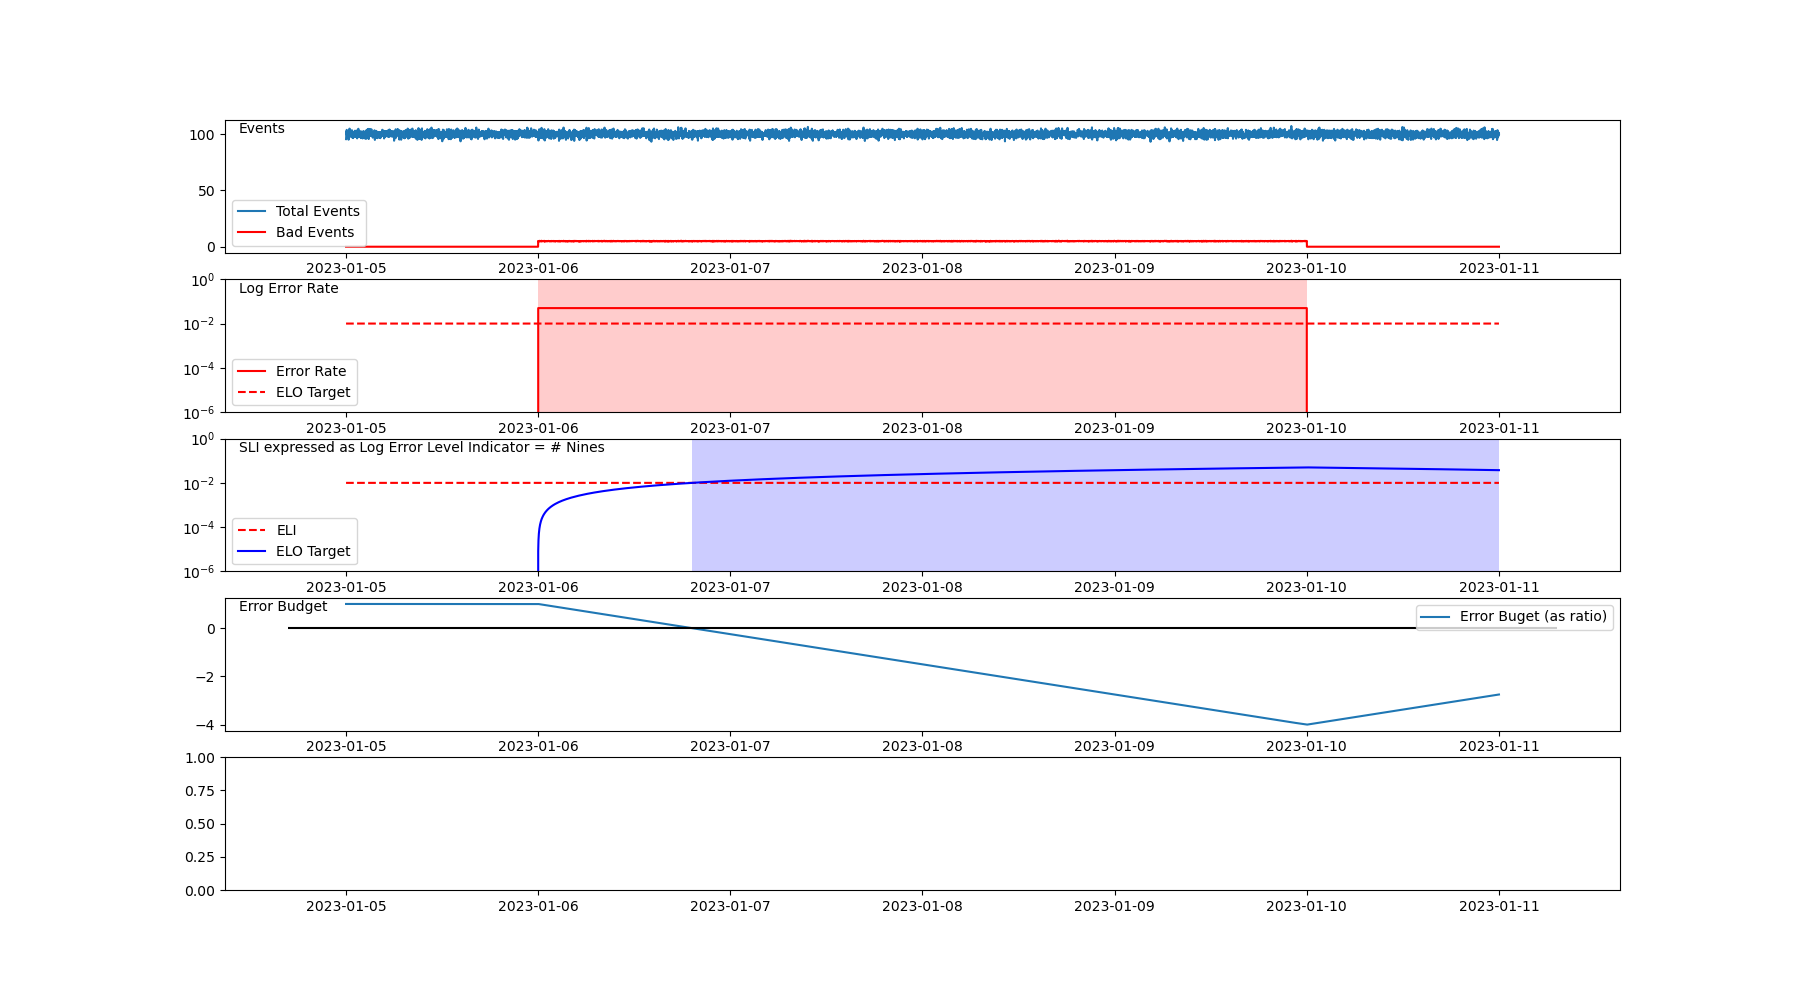

In [11]:
df = df_step("10d", "4d", 0.05)
df_add_slo(df, "4d", 0.99)
slo_plot(df, clip=True);

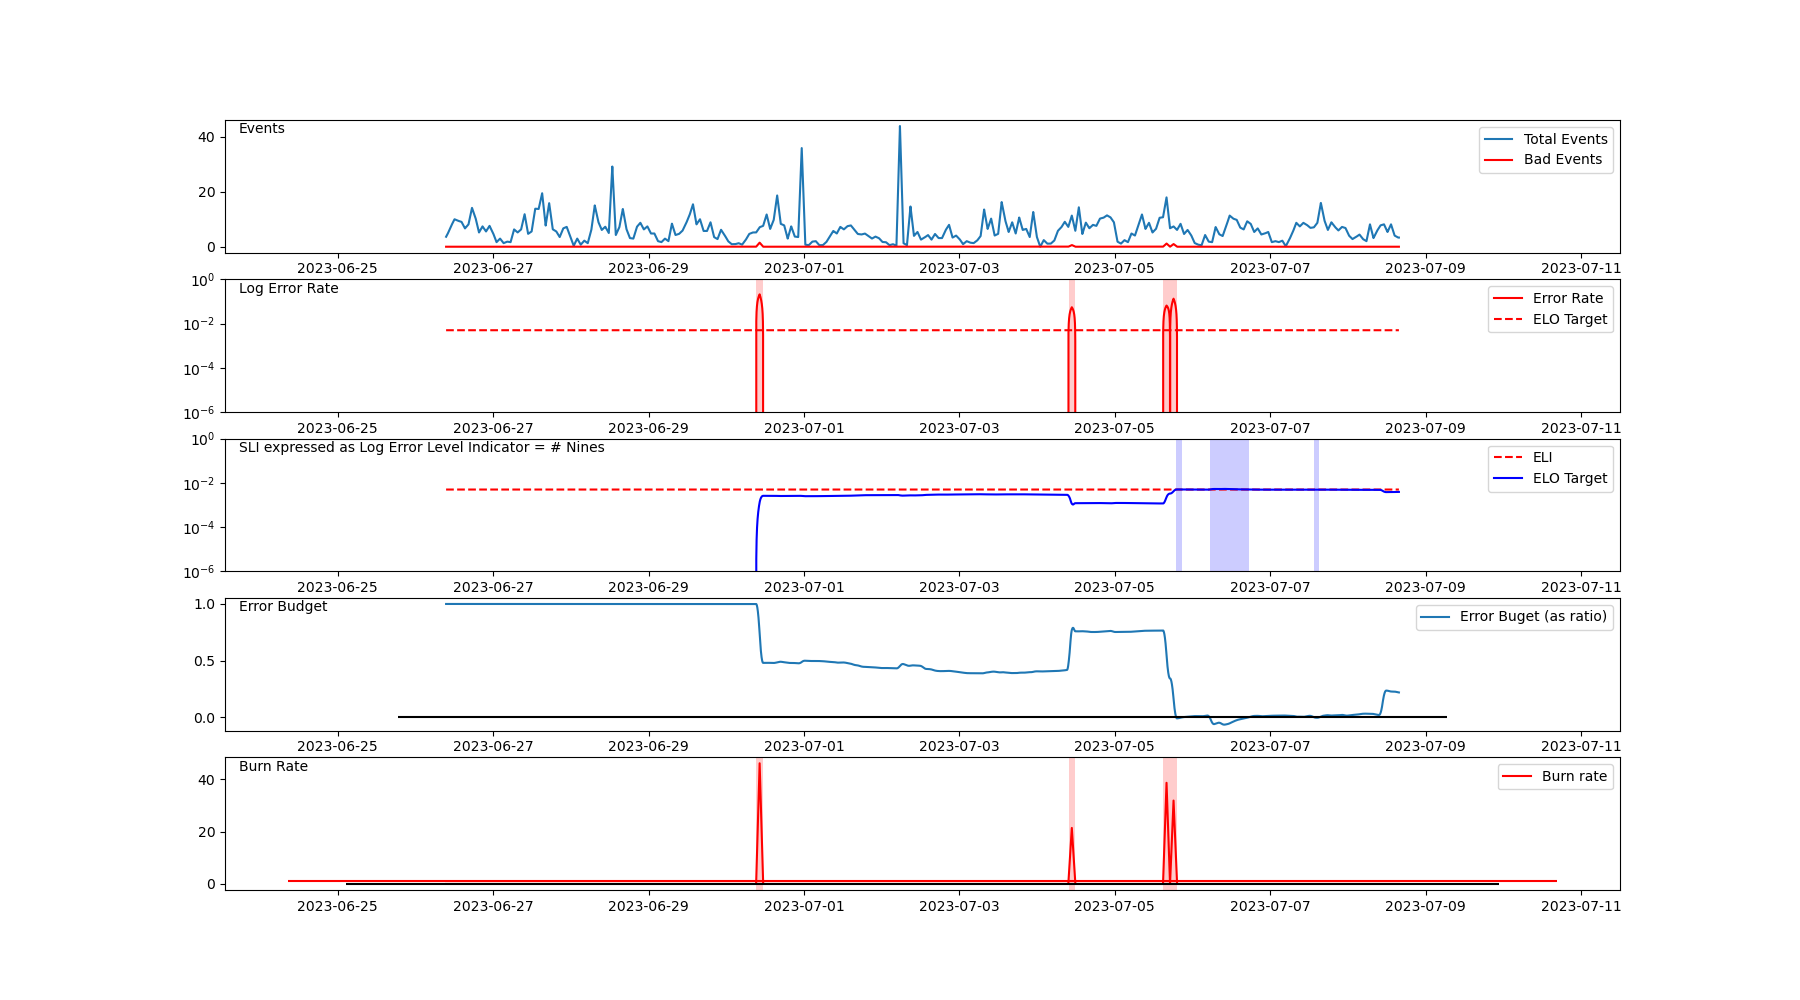

In [11]:
df = df_grafana()
df_add_slo(df, "4d", 0.995)
slo_plot(df, clip=True);

## SLO Alerts v1 - Average Error Rate ≥ SLO Threshold

In this method, we alert if the Error Rate is larger than the SLO threshold when averaged over a given time period.

This is equivalent to alerting when the Error Budget was depleted on the SLO with window size = time period.

In [12]:
def df_add_alert_v1(df, SLO_target, window_size="10m"):
    """
    Alert if the error rate over the time window of given size exceeds SLO target
    """
    window_size = pd.to_timedelta(window_size)
    df['alert_v1_ratio'] = df["bad"].rolling(window_size).sum() / df["total"].rolling(window_size).sum()
    df['alert'] = df['alert_v1_ratio'] >= (1-SLO_target)

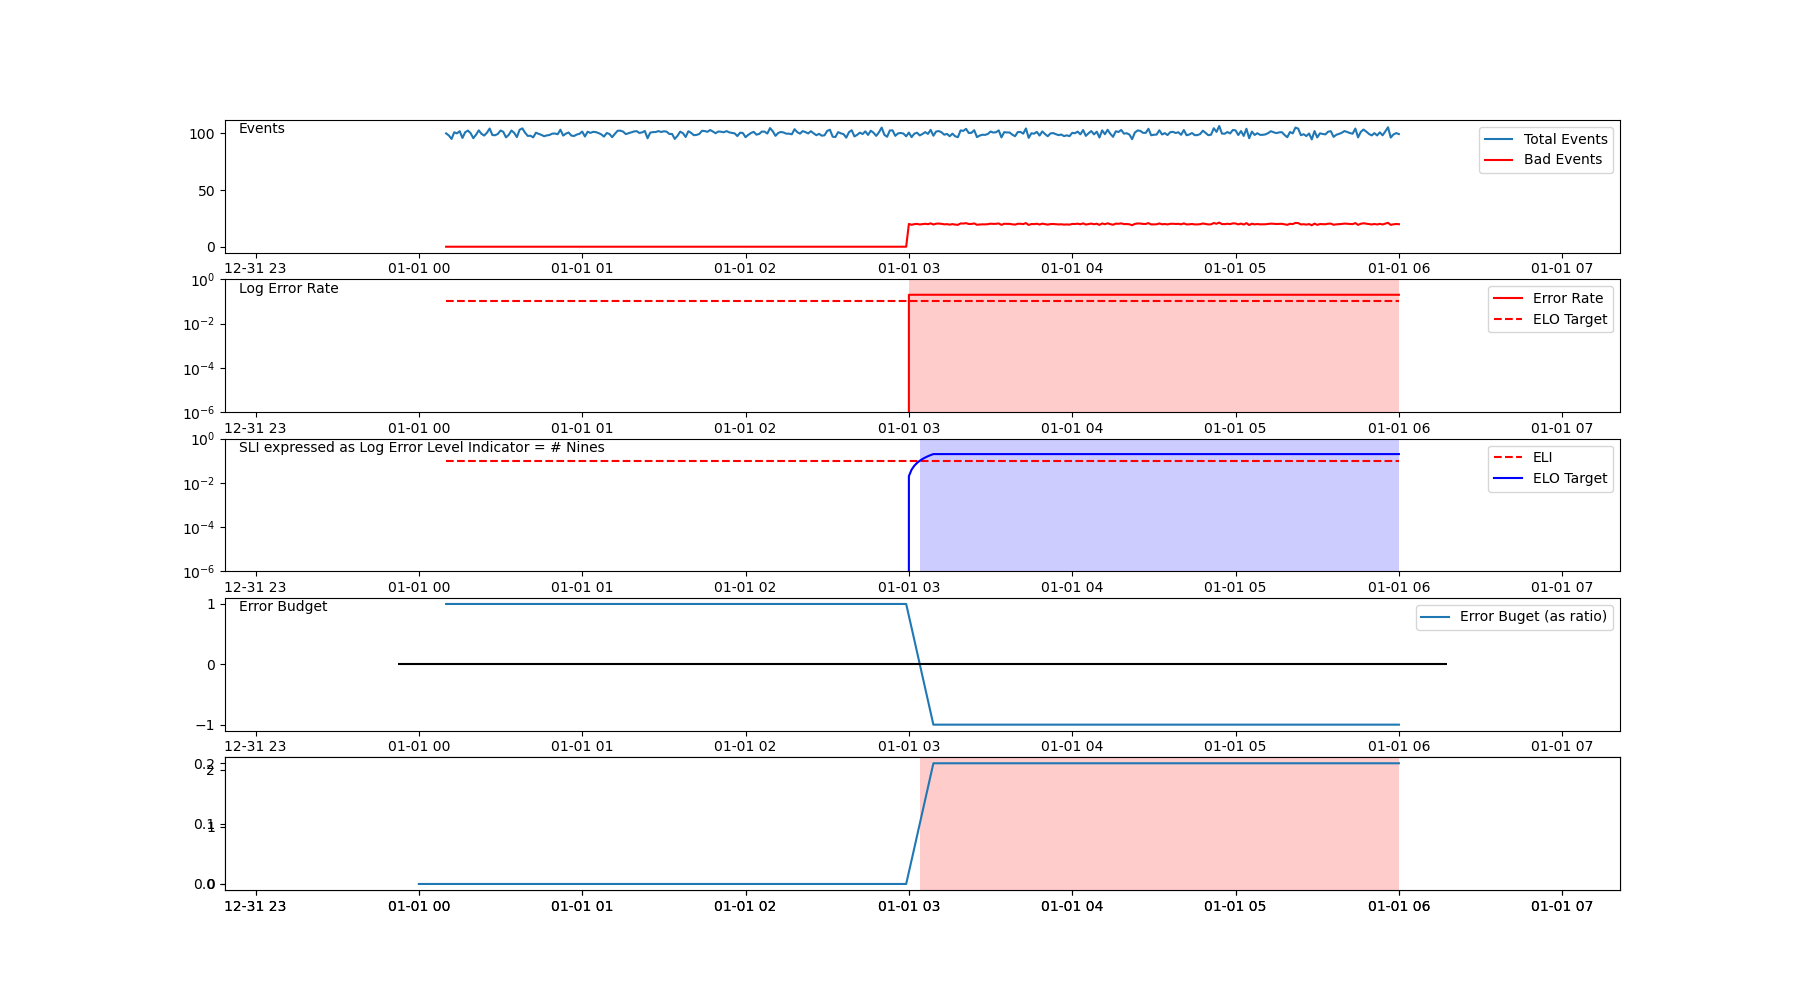

In [13]:
SLO_target = 0.9
window_size = "10m"
df = df_step("6h", "3h", 0.2)

df_add_slo(df, window_size, SLO_target)
df_add_alert_v1(df, SLO_target, window_size)

figure = slo_plot(df);
ax = figure.add_subplot(515, sharex=figure.axes[0])
ax.plot(df.alert_v1_ratio)
mark_true(ax, df["alert"])

# 3. Average Error Rate ≥ SLO Threshold for given Duration

Most monitoring systems allow you to add a duration parameter to the alert criteria so the alert won’t fire unless the value remains above the threshold for some time. You may be tempted to use this parameter as a relatively inexpensive way to add longer windows: 

In [140]:
def df_add_alert_v3(df, SLO_target, window_size="10m", hold_duration="1h"):
    """
    Alert if the error rate over the time window of given size exceeds SLO target
    """
    window_size = pd.to_timedelta(window_size)
    hold_duration = pd.to_timedelta(hold_duration)
    df['alert_v1_ratio'] = df["bad"].rolling(window_size).sum() / df["total"].rolling(window_size).sum()
    df['alert_v1'] = df['alert_v1_ratio'] >= (1-SLO_target)
    df['alert'] = df['alert_v1'].rolling(hold_duration).apply(lambda arr: arr.all())

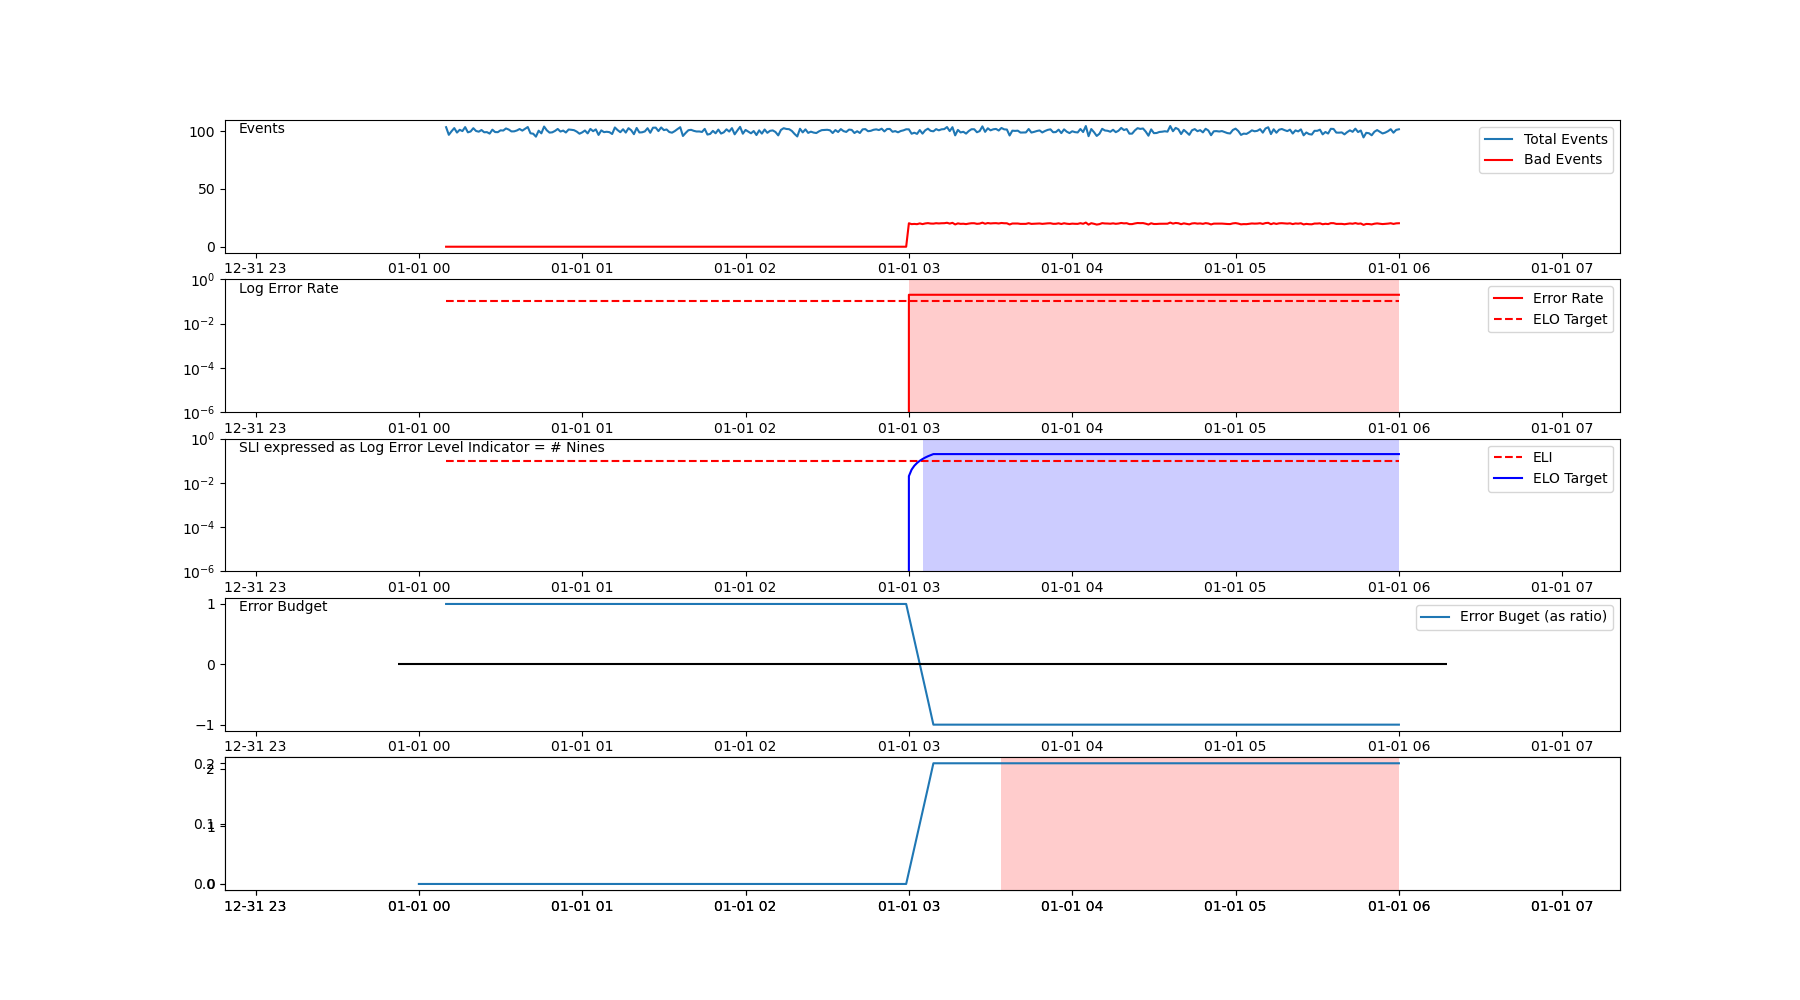

In [141]:
SLO_target = 0.9
window_size = "10m"
hold_duration = "30m"
df = df_step("6h", "3h", 0.20)

df_add_slo(df, window_size, SLO_target)
df_add_alert_v3(df, SLO_target, window_size, hold_duration)

figure = slo_plot(df);
ax = figure.add_subplot(515, sharex=figure.axes[0])
ax.plot(df.alert_v1_ratio)
mark_true(ax, df.alert)

# 4 Burnrate Alerts

Burnrate is defined by example:

* With burn_rate = 1, we deplete the error budget exactly until the SLO period is done
* With burn_rate = 2, we deplete the error budget in half the SLO period time
* Wint burn_rate = 30, we deplete the error budget in 1/30 of the SLO period. If SLO_period = 30d, then this is the case after one day.

In [45]:
def df_add_alert_bunrate(df, SLO_period, SLO_target, alert_duration="1h", alert_budget=0.05):
    """
    Alert if we sepent more than $(5%) of error budget over the last $(1h).
    """
    SLO_period = pd.to_timedelta(SLO_period)
    alert_duration = pd.to_timedelta(alert_duration)
    
    threshold = (1-SLO_target) * alert_budget
    df["alert_ratio"] = df['bad'].rolling(alert_duration).sum() / df["total"].rolling(SLO_period).sum() / threshold
    df["alert"] = df["alert_ratio"] > 1

In [46]:
def df_add_alert_bunrate_book(df, SLO_period, SLO_target, alert_duration="1h", alert_budget=0.05):
    """
    Alert if we sepent more than $(5%) of error budget over the last $(1h).
    """
    SLO_period = pd.to_timedelta(SLO_period)
    alert_duration = pd.to_timedelta(alert_duration)
    
    threshold = (1-SLO_target) * (SLO_period / alert_duration) * alert_budget
    df["alert_ratio"] = df['bad'].rolling(alert_duration).sum() / df["total"].rolling(alert_duration).sum() /  threshold
    df["alert"] = df["alert_ratio"] > 1

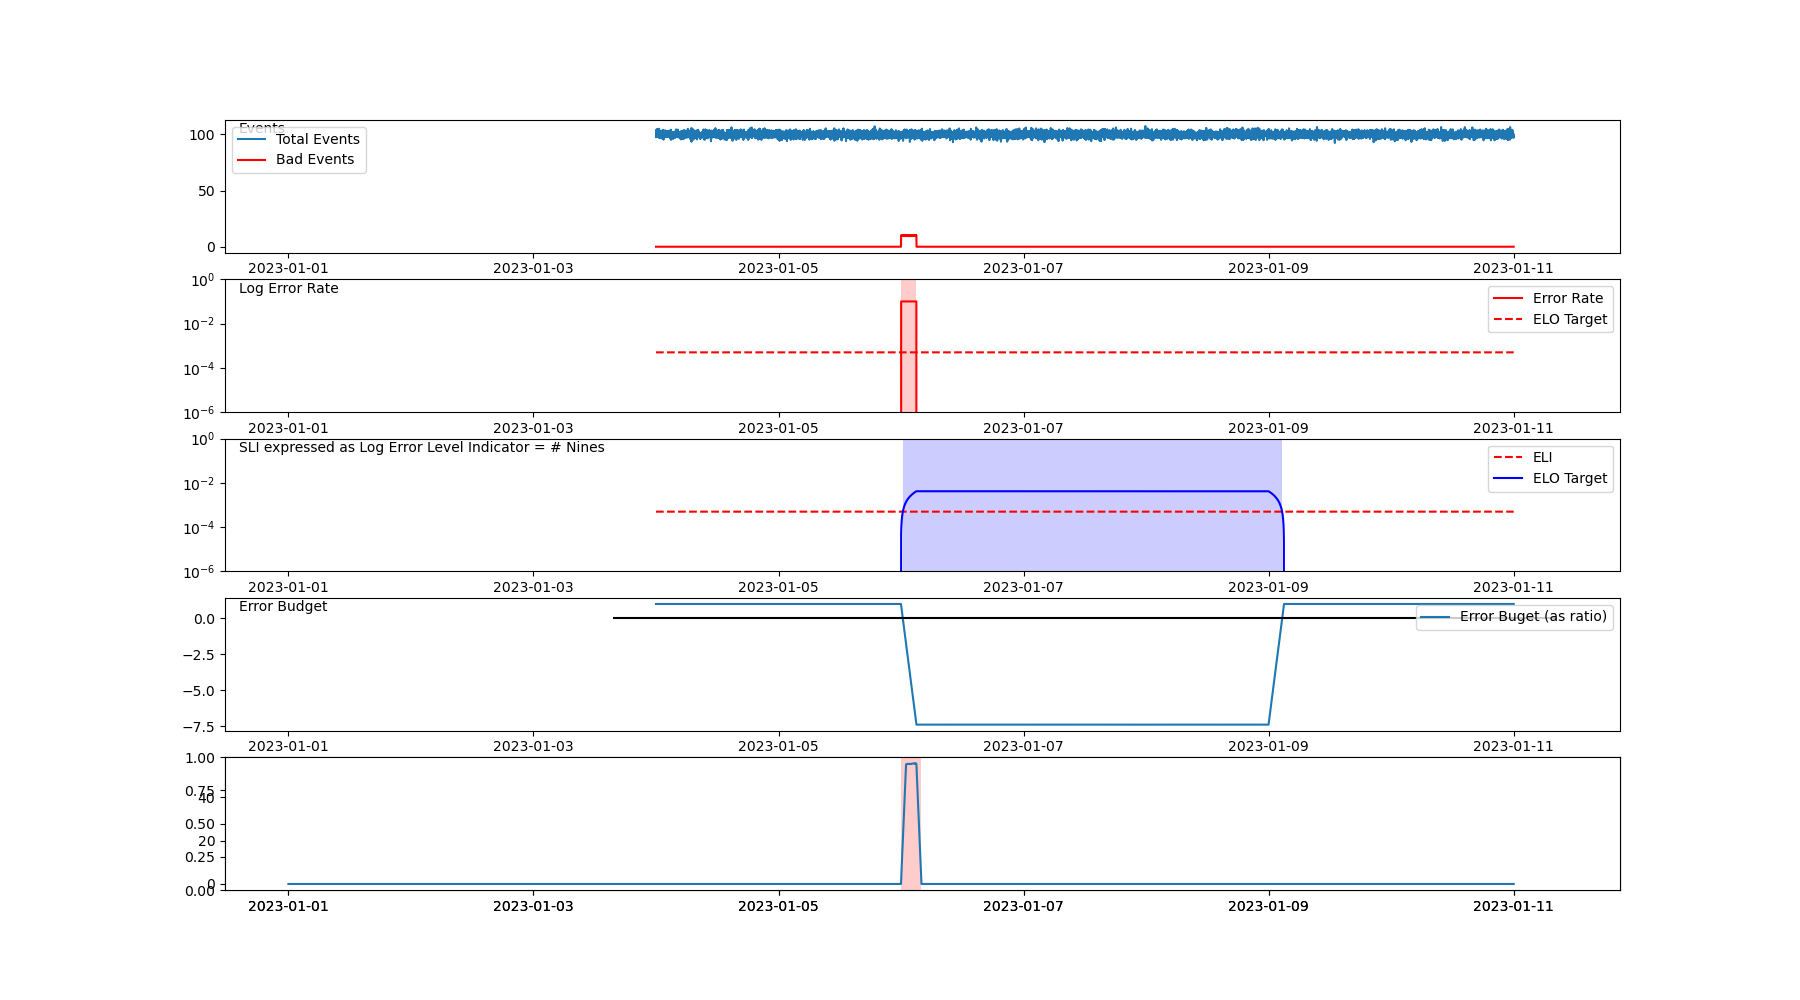

In [50]:
SLO_target = 0.9995
SLO_period = "3d"
alert_window_size = "1h"

df = df_step("10d", "3h", 0.1)

# df = df_grafana()

df_add_slo(df, SLO_period, SLO_target)
df_add_alert_bunrate(df, SLO_period, SLO_target, "1h", 0.05)

figure = slo_plot(df);
ax = figure.add_subplot(515, sharex=figure.axes[0])
ax.plot(df.alert_ratio)
mark_true(ax, df.alert)